In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution

['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [2]:
path_to_runs = Path("../../results/simulations/bribed_withdrawal_queue_replacement/")
times = []
common_data_dfs = []
timestep_data_dfs = []
proposal_data_dfs = []
for d in path_to_runs.iterdir():
    d_modified_time = d.stat().st_mtime
    times.append(d_modified_time)

    common_data_path = d.joinpath('common_data.parquet')
    common_data_df = pd.read_parquet(common_data_path)
    common_data_dfs.append(common_data_df)

    timestep_data_path = d.joinpath('timestep_data.parquet')
    timestep_data_df = pd.read_parquet(timestep_data_path)
    timestep_data_dfs.append(timestep_data_df)

    proposal_data_path = d.joinpath('proposals_data.parquet')
    proposal_data_df = pd.read_parquet(proposal_data_path)
    proposal_data_dfs.append(proposal_data_df)

proposal_data_df_full = pd.concat(proposal_data_dfs)
timestep_data_df_full = pd.concat(timestep_data_dfs)
common_data_df_full = pd.concat(common_data_dfs)

run_ids = {common_data_df_full.simulation_hash.iloc[i]: i for i in range(len(common_data_df_full))}
proposal_data_df_full['run_id'] = proposal_data_df_full.simulation_hash.apply(lambda x: run_ids[x])
timestep_data_df_full['run_id'] = timestep_data_df_full.simulation_hash.apply(lambda x: run_ids[x])
common_data_df_full['run_id'] = common_data_df_full.simulation_hash.apply(lambda x: run_ids[x])

proposal_data_df_full.reset_index(drop=True, inplace=True)
timestep_data_df_full.reset_index(drop=True, inplace=True)
common_data_df_full.reset_index(drop=True, inplace=True)


In [3]:
common_data_df_full.columns

Index(['seed', 'first_seal_rage_quit_support', 'second_seal_rage_quit_support',
       'attacker_funds', 'simulation_hash', 'determining_factor', 'n_actors',
       'quick_and_normal_early_responders_count',
       'quick_and_normal_early_responders_stETH_funds',
       'quick_and_normal_early_responders_wstETH_funds',
       'quick_and_normal_honest_actors_stETH_funds',
       'quick_and_normal_honest_actors_wstETH_funds', 'Normal', 'Quick',
       'Slow', 'NoReaction', 'BaseActor', 'HonestActor', 'SingleAttacker',
       'CoordinatedAttacker', 'Hacker', 'SingleDefender',
       'CoordinatedDefender', 'run_id'],
      dtype='object')

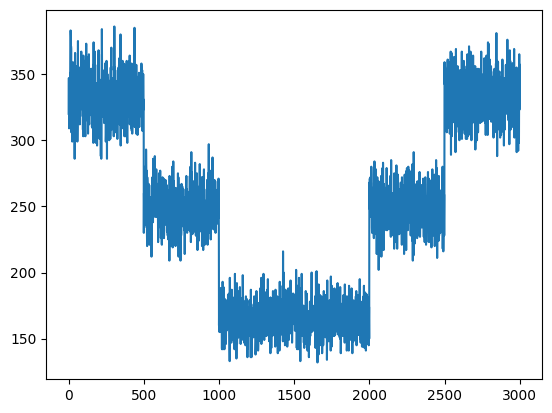

In [4]:
plt.plot(common_data_df_full.run_id, common_data_df_full.quick_and_normal_early_responders_count)

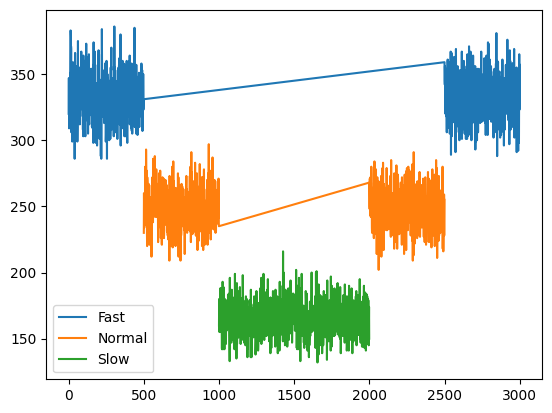

In [5]:
common_data_df_full['Reactions'] = 'Slow'

normal_index = np.concatenate([common_data_df_full.index[500:1000], common_data_df_full.index[2000:2500]])
fast_index = np.concatenate([common_data_df_full.index[:500], common_data_df_full.index[2500:]])
common_data_df_full.loc[normal_index, 'Reactions'] = 'Normal'
common_data_df_full.loc[fast_index, 'Reactions'] = 'Fast'

for reaction in ['Fast', 'Normal', 'Slow']:
    plt.plot(common_data_df_full[common_data_df_full.Reactions == reaction].run_id, common_data_df_full[common_data_df_full.Reactions == reaction].quick_and_normal_early_responders_count, label=reaction)
plt.legend();


In [6]:
common_data_df_full['early_responders_count'] = common_data_df_full.quick_and_normal_early_responders_count
common_data_df_full['early_responders_tokens'] = common_data_df_full.quick_and_normal_early_responders_stETH_funds + common_data_df_full.quick_and_normal_early_responders_wstETH_funds

total_funds = timestep_data_df_full.groupby('run_id').actors_total_balance.first()
common_data_df_full['early_responders_tokens_relative'] = (
    common_data_df_full['early_responders_tokens'] / 
    common_data_df_full['run_id'].map(total_funds)
)

In [7]:
common_data_df_full['early_responders_tokens_relative']

0       0.022557
1       0.026392
2       0.027655
3       0.022113
4       0.023785
          ...   
2995    0.023007
2996    0.026449
2997    0.026895
2998    0.025680
2999    0.027505
Name: early_responders_tokens_relative, Length: 3000, dtype: float64

In [10]:
common_data_df_full['amount_needed_to_bribe'] = common_data_df_full['early_responders_tokens_relative'] - 0.01

agg_results = common_data_df_full.groupby('Reactions').agg(
    {
        'early_responders_count': ('median', 'min', 'max'),
        'early_responders_tokens_relative': ('median', 'min', 'max'),
        'amount_needed_to_bribe': ('median', 'min', 'max')
    }
)
agg_results = agg_results.clip(lower=0)
agg_results

early_responders_count           early_responders_tokens_relative  \
                          median  min  max                           median   
Reactions                                                                     
Fast                       332.0  286  386                         0.024882   
Normal                     249.0  202  297                         0.018614   
Slow                       165.0  132  216                         0.012358   

                              amount_needed_to_bribe                      
                min       max                 median       min       max  
Reactions                                                                 
Fast       0.019675  0.029808               0.014882  0.009675  0.019808  
Normal     0.014392  0.023741               0.008614  0.004392  0.013741  
Slow       0.009085  0.016646               0.002358  0.000000  0.006646

## Bribing additional scenario

Now briber randomly selects certain number of token-holders to bribe. And we calculate 

In [27]:
dir_prev = Path("../../results/simulations/bribed_withdrawal_queue_replacement/")
times = []
common_data_dfs = []
timestep_data_dfs = []
proposal_data_dfs = []
for reactions in ['accelerated', 'normal', 'slowed']:
    path_to_runs = dir_prev.parent.joinpath(dir_prev.name + '_' + reactions)
    for d in path_to_runs.iterdir():
        d_modified_time = d.stat().st_mtime
        times.append(d_modified_time)

        common_data_path = d.joinpath('common_data.parquet')
        common_data_df = pd.read_parquet(common_data_path)
        common_data_dfs.append(common_data_df)

        timestep_data_path = d.joinpath('timestep_data.parquet')
        timestep_data_df = pd.read_parquet(timestep_data_path)
        timestep_data_dfs.append(timestep_data_df)

        proposal_data_path = d.joinpath('proposals_data.parquet')
        proposal_data_df = pd.read_parquet(proposal_data_path)
        proposal_data_dfs.append(proposal_data_df)

        common_data_df['reactions'] = reactions

proposal_data_df_full = pd.concat(proposal_data_dfs)
timestep_data_df_full = pd.concat(timestep_data_dfs)
common_data_df_full = pd.concat(common_data_dfs)

run_ids = {common_data_df_full.simulation_hash.iloc[i]: i for i in range(len(common_data_df_full))}
proposal_data_df_full['run_id'] = proposal_data_df_full.simulation_hash.apply(lambda x: run_ids[x])
timestep_data_df_full['run_id'] = timestep_data_df_full.simulation_hash.apply(lambda x: run_ids[x])
common_data_df_full['run_id'] = common_data_df_full.simulation_hash.apply(lambda x: run_ids[x])

proposal_data_df_full.reset_index(drop=True, inplace=True)
timestep_data_df_full.reset_index(drop=True, inplace=True)
common_data_df_full.reset_index(drop=True, inplace=True)


In [28]:
common_data_df_full.columns

Index(['seed', 'first_seal_rage_quit_support', 'second_seal_rage_quit_support',
       'attacker_funds', 'simulation_hash', 'determining_factor', 'n_actors',
       'quick_and_normal_early_responders_count',
       'quick_and_normal_early_responders_stETH_funds',
       'quick_and_normal_early_responders_wstETH_funds',
       'quick_and_normal_honest_actors_stETH_funds',
       'quick_and_normal_honest_actors_wstETH_funds', 'Normal', 'Quick',
       'Slow', 'NoReaction', 'BaseActor', 'HonestActor', 'SingleAttacker',
       'CoordinatedAttacker', 'Hacker', 'SingleDefender',
       'CoordinatedDefender', 'reactions', 'run_id'],
      dtype='object')

In [33]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals

columns = ('reactions', 'determining_factor',)
veto_stats = analyze_veto_timing_by_seals(timestep_data_df_full, common_data_df_full, additional_columns=columns)

# Calculate attack_success_rate
veto_stats['attack_success_rate'] = 100 - veto_stats['veto_rate']

# Reorder columns to place attack_success_rate before veto_rate
cols = list(veto_stats.columns)
veto_rate_index = cols.index('veto_rate')
cols.insert(veto_rate_index, cols.pop(cols.index('attack_success_rate')))
veto_stats = veto_stats[cols]

display(veto_stats.sort_values(by=list(columns)))


attack_success_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support reactions   determining_factor                        
10000000000000000            100000000000000000            accelerated 10                             0.000000   
                                                                       60                             0.000000   
                                                                       110                            0.000000   
                                                                       160                            1.800000   
                                                                       210                           68.500000   
                                                                       260                           99.600000   
                                                                       310                           99.900000   
                                                           normal      10                             0.000000   
                                                                       60                             0.297619   
                                                                       110                           38.392857   
                                                                       160                           98.792757   
                                                                       210                           99.899396   
                                                                       260                           99.899396   
                                                                       310                           99.899396   
                                                           slowed      10                             9.500000   
                                                                       60                            96.700000   
                                                                       110                           99.800000   
                                                                       160                           99.900000   
                                                                       210                           99.900000   
                                                                       260                           99.900000   
                                                                       310                           99.900000   

                                                                                            veto_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support reactions   determining_factor               
10000000000000000            100000000000000000            accelerated 10                  100.000000   
                                                                       60                  100.000000   
                                                                       110                 100.000000   
                                                                       160                  98.200000   
                                                                       210                  31.500000   
                                                                       260                   0.400000   
                                                                       310                   0.100000   
                                                           normal      10                  100.000000   
                                                                       60                   99.702381   
                                                                       110                  61.607143   
                                                                       160                   1.207243   
                                                                       210                   0.100604  